In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('website_ab_test.csv')

In [3]:
raw

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,No,Yes
1,Light Theme,0.113932,0.032973,0.732759,61.858568,19,Pune,303,No,Yes
2,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,Yes,Yes
3,Light Theme,0.485836,0.325225,0.245001,76.305298,58,Pune,385,Yes,No
4,Light Theme,0.034783,0.196766,0.765100,48.927407,25,New Delhi,1437,No,No
...,...,...,...,...,...,...,...,...,...,...
995,Dark Theme,0.282792,0.401605,0.200720,68.478822,25,Kolkata,321,Yes,Yes
996,Dark Theme,0.299917,0.026372,0.762641,73.019821,38,Chennai,1635,Yes,Yes
997,Light Theme,0.370254,0.019838,0.607136,33.963298,32,Bangalore,1237,No,Yes
998,Light Theme,0.095815,0.137953,0.458898,37.429284,24,Chennai,893,Yes,No


In [4]:
map_themes = {'Light Theme': 0, 'Dark Theme': 1}
map_binary = {'No': 0, 'Yes': 1}
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
raw['Theme'] = raw['Theme'].map(map_themes)
raw['Location'] = LE.fit_transform(raw['Location'])
raw['Purchases'] = raw['Purchases'].map(map_binary)
raw['Added_to_Cart'] = raw['Added_to_Cart'].map(map_binary)

## Hypothesis 1:
Light Theme users are more likely to add something to their carts than dark users

H_a: Mu1 <= Mu2

H_0: Mu1 > Mu2

In [5]:
# split into two groups
light = raw.query('Theme == 0')
dark = raw.query('Theme == 1')

In [6]:
# randomly sample 150 points from each group with no replacement; 300 total
light_sample = light.sample(150, replace=False)
dark_sample = dark.sample(150, replace=False)

In [7]:
from scipy.stats import ttest_ind

# t-test time
t,p = ttest_ind(light_sample['Added_to_Cart'], dark_sample['Added_to_Cart'], equal_var=False)

print("t-statistic: ", t)
print("p-value: ", p)

t-statistic:  1.9727240829054609
p-value:  0.04945128094355921


Given an alpha of 0.05; p > alpha (0.205) so we fail to reject the null hypothesis. Light theme users appear to be more likely to add something to their cart than dark users.

## One way Analysis of Variance

Definitions:

Click through rate (CTR): Measures how often people click on an ad, email, or webpage after seeing it.
Conversion rate (CR): Percentage which measures how many users complete a given action after interacting with a digital asset.
Bounce rate (BR): Measures the percentage of visitors to a website who leave after viewing only one page.

We postulate the following hypothesis for ANOVA:

***H0: Means of CTR for each group are the same***

***Ha: At least one of the means is different***


We first check the assumptions to see if an ANOVA will be useful:

In [8]:
import statsmodels.api as sm
import seaborn as sns

sample_data = pd.concat([light_sample, dark_sample], axis=0)

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


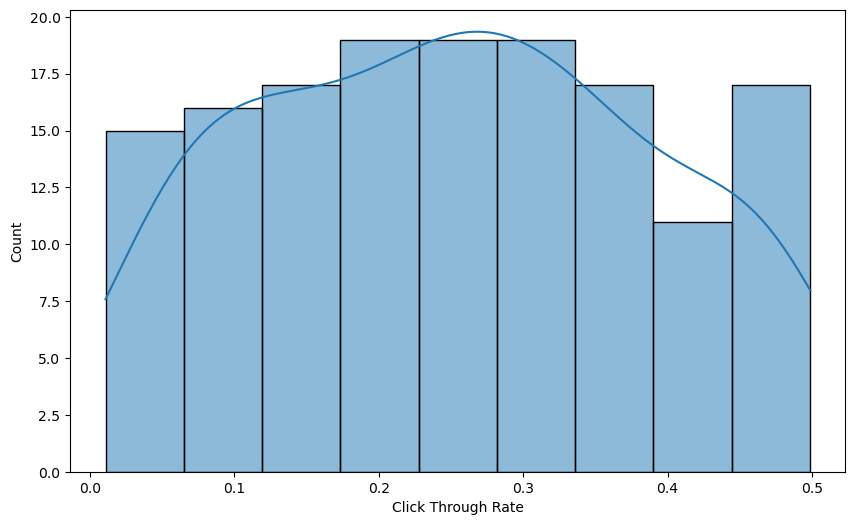

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(light_sample, x='Click Through Rate', kde=True)
plt.show()

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


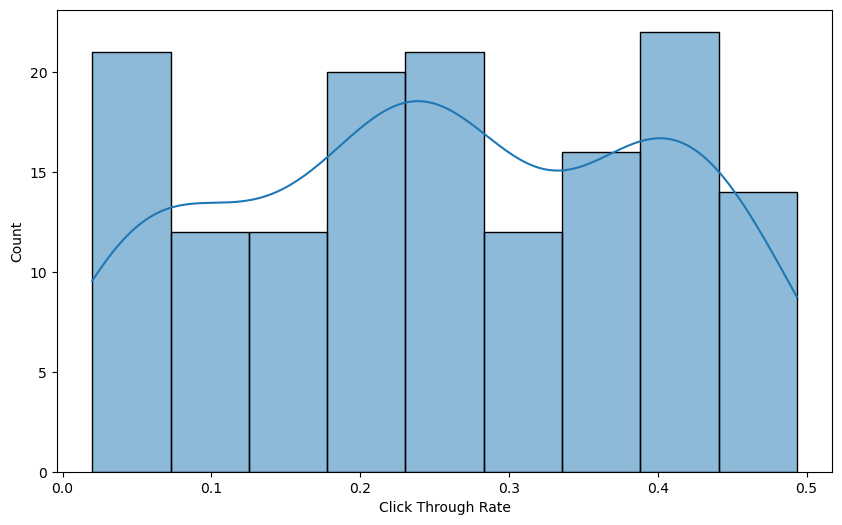

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(dark_sample, x='Click Through Rate', kde=True)
plt.show()

<Figure size 1000x600 with 0 Axes>

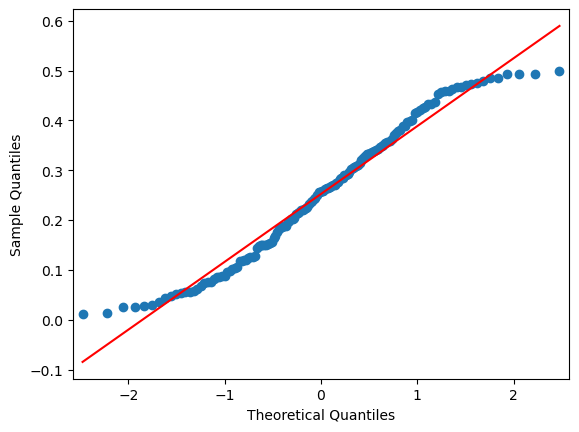

In [11]:
plt.figure(figsize=(10, 6))
sm.qqplot(light_sample['Click Through Rate'], line='s')
plt.show()

<Figure size 1000x600 with 0 Axes>

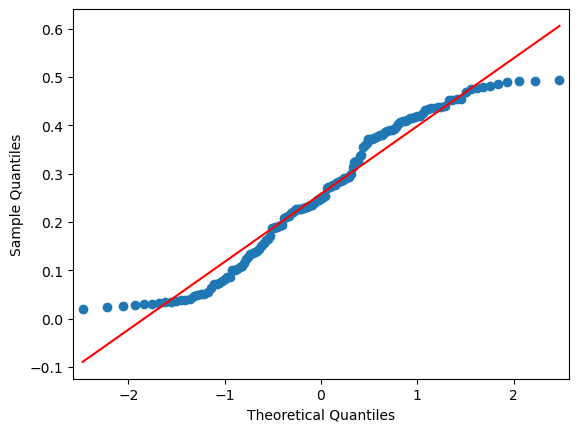

In [12]:
plt.figure(figsize=(10, 6))
sm.qqplot(dark_sample['Click Through Rate'], line='s')
plt.show()

In [15]:
c = sample_data[['Theme','Click Through Rate']].corr()
#mask = np.triu(np.ones_like(c, dtype=bool))

print('Correlation between Theme and CTR:', c['Click Through Rate']['Theme'])

Correlation between Theme and CTR: 0.020230720339925484


In [18]:
sample_data.groupby('Theme', as_index=False)['Click Through Rate'].describe()

,Theme,count,mean,std,min,25%,50%,75%,max
0,0,150.0,0.252551,0.136516,0.010767,0.144893,0.257072,0.354064,0.498659
1,1,150.0,0.258146,0.140900,0.019964,0.141005,0.249569,0.384744,0.493401


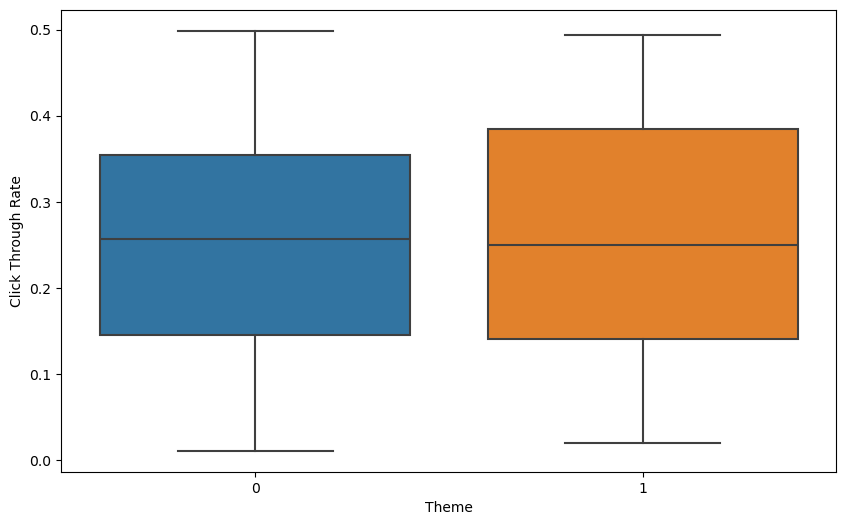

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=sample_data, x='Theme', y='Click Through Rate')
plt.show()

Since the sample data is non-normal and the qq-plots show that the data follows a logistic pattern, this data is non-linear. There is weak positive correlation between Theme and CTR. We can assume that the data is normal because CLT is applicable, as `n=300`. The requirement for constant standard deviation is also satisfied as `2 * smallest std (0.136516) = 0.273032` is greater than the largest standard deviation of `0.140900`. There also appear to be no outliers in the sample for each group.

In [21]:
# 1 way ANOVA
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(light_sample['Click Through Rate'], dark_sample['Click Through Rate'])

print("F-statistic:", f_stat)
print("P-value:", p_val)

F-statistic: 0.12201598850408665
P-value: 0.7271048931761545


In [23]:
anova_data = sample_data[['Theme', 'Click Through Rate']]
anova_data

,Theme,Click Through Rate
528,0,0.498659
258,0,0.029180
84,0,0.221619
114,0,0.340739
404,0,0.182880
...,...,...
626,1,0.382726
758,1,0.491308
938,1,0.229783
55,1,0.071834


In [25]:
anova_data.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)
anova_data.columns

C:\Users\ldmag\AppData\Local\Temp\ipykernel_34748\3351835921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_data.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)


Index(['Theme', 'CTR'], dtype='object')

In [26]:
# ANOVA table
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('CTR ~ C(Theme)', anova_data).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)

            sum_sq     df         F    PR(>F)
C(Theme)  0.002348    1.0  0.122016  0.727105
Residual  5.734937  298.0       NaN       NaN


In [31]:
variance = anova_data['CTR'].var()
explained_variance = table['sum_sq']['C(Theme)'] / variance * 100

print(f'Explained Variance: {explained_variance:.2f}')

Explained Variance: 12.24


Based on the following p-value of 0.727, and an alpha of 0.05: we fail to reject the null hypothesis. The mean CTR between both groups appear to be the same. Approximately 12.24% of the variance in the response variable 'Theme' is explained by the CTR variable. 

## Two Way Analysis of Variance

For a two way ANOVA we need multiple categoric variables and a continuous response. We use the location variable and split the data on three categories: 'North India', 'South India', and 'Coastal India', under the new variable 'Region'. We will then attempt to examine the relationship between CTR, Theme, and Region. 

We can state the following hypotheses:

H0: There is no difference in the mean CTR for any Region and Theme.

Ha: There is a difference in mean CTR for one or more regions and themes.

In [37]:
inverse_theme = {v: k for k, v in map_themes.items()}

In [57]:
raw

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart,Region
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,0,1,South
1,Light Theme,0.113932,0.032973,0.732759,61.858568,19,Pune,303,0,1,North
2,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,1,1,South
3,Light Theme,0.485836,0.325225,0.245001,76.305298,58,Pune,385,1,0,North
4,Light Theme,0.034783,0.196766,0.765100,48.927407,25,New Delhi,1437,0,0,North
...,...,...,...,...,...,...,...,...,...,...,...
995,Dark Theme,0.282792,0.401605,0.200720,68.478822,25,Kolkata,321,1,1,Coastal
996,Dark Theme,0.299917,0.026372,0.762641,73.019821,38,Chennai,1635,1,1,South
997,Light Theme,0.370254,0.019838,0.607136,33.963298,32,Bangalore,1237,0,1,South
998,Light Theme,0.095815,0.137953,0.458898,37.429284,24,Chennai,893,1,0,South


In [41]:
raw['Theme'] = raw['Theme'].map(inverse_theme)
raw['Location'] = LE.inverse_transform(raw['Location'])

In [44]:
raw['Region'] = ''
raw.loc[(raw['Location'] == 'Kolkata') | (raw['Location'] == 'Mumbai'), 'Region'] = 'Coastal'
raw.loc[(raw['Location'] == 'Pune') | (raw['Location'] == 'New Delhi'), 'Region'] = 'North'
raw.loc[(raw['Location'] == 'Bangalore') | (raw['Location'] == 'Chennai'), 'Region'] = 'South'

In [48]:
# randomly sample 300 datapoints
sample_data2 = raw.sample(n=300, random_state=42)
sample_data2.describe()

,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Session_Duration,Purchases,Added_to_Cart
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.259842,0.250083,0.500102,49.697928,41.850000,927.460000,0.503333,0.516667
std,0.136006,0.143685,0.174326,16.660757,14.387175,496.985093,0.500824,0.500557
min,0.018933,0.011259,0.200720,20.211974,18.000000,46.000000,0.000000,0.000000
25%,0.149469,0.130255,0.336708,35.428048,29.000000,503.750000,0.000000,0.000000
50%,0.260351,0.263629,0.524255,49.688709,42.000000,927.000000,1.000000,1.000000
75%,0.364141,0.367991,0.647332,63.797461,55.000000,1355.000000,1.000000,1.000000
max,0.499989,0.498874,0.794046,79.842038,65.000000,1795.000000,1.000000,1.000000


In [61]:
two_anovaData = sample_data2[['Click Through Rate', 'Theme', 'Region']]
two_anovaData.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)

C:\Users\ldmag\AppData\Local\Temp\ipykernel_34748\297142345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_anovaData.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)


In [62]:
two_anovaData

,CTR,Theme,Region
521,0.350051,Light Theme,North
737,0.366427,Dark Theme,South
740,0.284835,Dark Theme,North
660,0.062674,Light Theme,South
411,0.276600,Light Theme,North
...,...,...,...
468,0.220998,Light Theme,North
935,0.482253,Dark Theme,North
428,0.182627,Light Theme,North
7,0.395619,Light Theme,South


In [63]:
two_anovaData.groupby('Region', as_index=False)['CTR'].describe()

,Region,count,mean,std,min,25%,50%,75%,max
0,Coastal,62.0,0.256558,0.137862,0.018933,0.144895,0.272815,0.374402,0.499989
1,North,117.0,0.269448,0.139791,0.025869,0.163149,0.274482,0.373037,0.499328
2,South,121.0,0.252235,0.131850,0.028358,0.140693,0.239864,0.359551,0.498610


In [64]:
# Applying the two way anova

model2 = ols('CTR ~ C(Region) + C(Theme) + C(Region):C(Theme)', data=two_anovaData).fit()
table2 = sm.stats.anova_lm(model2, typ=2)

print(table2)

                      sum_sq     df         F    PR(>F)
C(Region)           0.024032    2.0  0.656074  0.519642
C(Theme)            0.085265    1.0  4.655358  0.031767
C(Region):C(Theme)  0.042340    2.0  1.155857  0.316214
Residual            5.384714  294.0       NaN       NaN


Based on the p-values obtained; we can determine that the 'Theme' variable has the most significant influence over CTR (p=0.0318). Region and a combination of Region + Theme are determined to be not significant (p=0.520 and p=0.316); assuming an alpha of 0.05. 